# 📊 Food Safety Event Detection - Comprehensive Exploratory Data Analysis

**Project**: Automated Food Safety Event Detection from News Articles using LLMs  
**Author**: Lowren Hwa  
**Date**: 2025-10-05  

---

## 🗂️ Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Dataset Overview](#2-overview)
3. [Label Distribution Analysis](#3-labels)
4. [Text Analysis](#4-text)
5. [Temporal Analysis](#5-temporal)
6. [Entity Analysis](#6-entities)
7. [Multi-Label Investigation](#7-multilabel)
8. [Key Findings & Recommendations](#8-findings)

---

<a id='1-setup'></a>
## 1. 🔧 Setup & Data Loading

In [1]:
# Core libraries
import json
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from datetime import datetime

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# NLP
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Text statistics
import textstat

# Progress bar
from tqdm.auto import tqdm

# Rich console output
from rich.console import Console
from rich.table import Table
from rich import print as rprint

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Plotly template
import plotly.io as pio
pio.templates.default = "plotly_white"

# Color palette (colorblind-friendly)
COLORS = px.colors.qualitative.Safe

console = Console()
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Download NLTK data
for resource in ['punkt', 'stopwords', 'averaged_perceptron_tagger', 'punkt_tab']:
    try:
        nltk.download(resource, quiet=True)
    except:
        pass

print("✅ NLTK resources downloaded!")

✅ NLTK resources downloaded!


In [3]:
# Load data
DATA_DIR = Path('../data/event_detection_data')

with open(DATA_DIR / 'train_entities.json', 'r') as f:
    train_data = json.load(f)

with open(DATA_DIR / 'test_entities.json', 'r') as f:
    test_data = json.load(f)

console.print(f"[green]✅ Data loaded successfully![/green]")
console.print(f"Training samples: {len(train_data):,}")
console.print(f"Test samples: {len(test_data):,}")
console.print(f"Total samples: {len(train_data) + len(test_data):,}")

✅ Data loaded successfully!

Training samples: 2,011

Test samples: 258

Total samples: 2,269

In [4]:
# Convert to DataFrames
def parse_data(data):
    """Convert JSON data to DataFrame with extracted features."""
    records = []
    for item in tqdm(data, desc="Parsing data"):
        record = {
            'id': item['id'],
            'title': item['title'],
            'text': item['text'],
            'type': item['type'],
            'date': item.get('date', None),  # Handle missing date
            'url': item.get('url', None),    # Handle missing url
            'num_sentences': len(item['entities']),
        }
        records.append(record)
    return pd.DataFrame(records)

df_train = parse_data(train_data)
df_test = parse_data(test_data)

# Add split column
df_train['split'] = 'train'
df_test['split'] = 'test'

# Combine for some analyses
df_all = pd.concat([df_train, df_test], ignore_index=True)

console.print("[green]✅ DataFrames created![/green]")
console.print(f"[yellow]Note: {df_all['date'].isna().sum()} samples missing date, {df_all['url'].isna().sum()} missing URL[/yellow]")
df_train.head(3)

Parsing data:   0%|          | 0/2011 [00:00<?, ?it/s]

Parsing data:   0%|          | 0/258 [00:00<?, ?it/s]

✅ DataFrames created!

Note: 523 samples missing date, 62 missing URL

,id,title,text,type,date,url,num_sentences,split
0,793,"If farmer doesn’t quickly pay $250,000 contempt fine, jail could become option",Editor’s Note: The sanctions Amos Miller may face for being found in contempt of court are conta...,Negative,"July 1, 2021",https://www.foodsafetynews.com/2021/07/if-farmer-doesnt-quickly-pay-250000-contempt-fine-jail-co...,44,train
1,1145,Could cold plasma be the future of food safety? The evidence is mounting,"Cold plasma has captured scientists’ imagination in almost every field, and food safety is no ex...",Negative,"October 13, 2021",https://www.foodsafetynews.com/2021/10/could-cold-plasma-be-the-future-of-food-safety-the-eviden...,24,train
2,187,Rise in home-based businesses creates new safety worries amid pandemic,A non-profit group has added its voice to a chorus of growing safety concerns about the rise in ...,Negative,"February 19, 2021",https://www.foodsafetynews.com/2021/02/rise-in-home-based-businesses-creates-new-safety-worries-...,29,train


<a id='2-overview'></a>
## 2. 📋 Dataset Overview

In [5]:
# Dataset statistics
table = Table(title="📊 Dataset Statistics", show_header=True, header_style="bold magenta")
table.add_column("Metric", style="cyan")
table.add_column("Train", justify="right")
table.add_column("Test", justify="right")
table.add_column("Total", justify="right", style="bold")

table.add_row("Samples", f"{len(df_train):,}", f"{len(df_test):,}", f"{len(df_all):,}")
table.add_row("Unique IDs", f"{df_train['id'].nunique():,}", f"{df_test['id'].nunique():,}", f"{df_all['id'].nunique():,}")
table.add_row("Unique Labels", f"{df_train['type'].nunique()}", f"{df_test['type'].nunique()}", f"{df_all['type'].nunique()}")

# Handle date range with missing values
train_dates = df_train['date'].dropna()
test_dates = df_test['date'].dropna()
all_dates = df_all['date'].dropna()

if len(train_dates) > 0 and len(test_dates) > 0 and len(all_dates) > 0:
    table.add_row("Date Range", 
                 f"{train_dates.min()[:4]} - {train_dates.max()[:4]}",
                 f"{test_dates.min()[:4]} - {test_dates.max()[:4]}",
                 f"{all_dates.min()[:4]} - {all_dates.max()[:4]}")
else:
    table.add_row("Date Range", "N/A", "N/A", "N/A")

table.add_row("Missing Values", 
             f"{df_train.isnull().sum().sum()}",
             f"{df_test.isnull().sum().sum()}",
             f"{df_all.isnull().sum().sum()}")

console.print(table)

                   📊 Dataset Statistics                    
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Metric         ┃       Train ┃        Test ┃       Total ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Samples        │       2,011 │         258 │       2,269 │
│ Unique IDs     │       1,643 │         254 │       1,805 │
│ Unique Labels  │           7 │           7 │           7 │
│ Date Range     │ 2021 - http │ 2021 - http │ 2021 - http │
│ Missing Values │         526 │          59 │         585 │
└────────────────┴─────────────┴─────────────┴─────────────┘

In [6]:
# Train/Test split visualization
split_counts = df_all['split'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=['Training', 'Test'],
    values=split_counts.values,
    hole=0.4,
    marker_colors=[COLORS[0], COLORS[1]],
    textinfo='label+percent+value',
    textfont_size=14,
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
)])

fig.update_layout(
    title_text='Train/Test Split Distribution',
    title_font_size=20,
    height=450,
    showlegend=True
)

fig.show()

In [7]:
# Sample article inspection
console.print("\n[bold cyan]📄 Sample Article:[/bold cyan]\n")
sample = df_train.iloc[0]
console.print(f"[yellow]Title:[/yellow] {sample['title']}")
console.print(f"[yellow]Type:[/yellow] {sample['type']}")
console.print(f"[yellow]Date:[/yellow] {sample['date'] if pd.notna(sample['date']) else 'N/A'}")
console.print(f"[yellow]Text Preview:[/yellow] {sample['text'][:500]}...")
console.print(f"[yellow]Text Length:[/yellow] {len(sample['text'])} characters")

📄 Sample Article:

Title: If farmer doesn’t quickly pay $250,000 contempt fine, jail could become option

Type: Negative

Date: July 1, 2021

Text Preview: Editor’s Note: The sanctions Amos Miller may face for being found in contempt of court are contained 
in a proposed Order from the Department of Justice.   At the time of this posting, the proposed order has not yet 
been acted on by the Court. Amos Miller and Miller’s Organic Farm — found in contempt on June 16 of a federal 
court’s 2019 injunction order and 2020 consent decree — are learning civil contempt sanctions can be costly. They 
may even include incarceration in federal prison. The governm...

Text Length: 9955 characters

<a id='3-labels'></a>
## 3. 🏷️ Label Distribution Analysis

In [8]:
# Class distribution
train_label_counts = df_train['type'].value_counts()
test_label_counts = df_test['type'].value_counts()

# Create comparison DataFrame
label_comparison = pd.DataFrame({
    'Train': train_label_counts,
    'Test': test_label_counts
}).fillna(0).astype(int)

label_comparison['Total'] = label_comparison['Train'] + label_comparison['Test']
label_comparison['Train %'] = (label_comparison['Train'] / len(df_train) * 100).round(2)
label_comparison['Test %'] = (label_comparison['Test'] / len(df_test) * 100).round(2)

# Sort by total
label_comparison = label_comparison.sort_values('Total', ascending=False)

console.print("\n[bold cyan]📊 Label Distribution:[/bold cyan]\n")
console.print(label_comparison)

📊 Label Distribution:

Train  Test  Total  Train %  Test %
type                                                                 
Negative                           1419   174   1593    70.56   67.44
Food Recall                         195    26    221     9.70   10.08
Zoonotic Disease                    172    25    197     8.55    9.69
Food Poisoning                      129    18    147     6.41    6.98
Food Poisoning; Food Recall          80    13     93     3.98    5.04
Zoonotic Disease; Food Poisoning     13     1     14     0.65    0.39
Food Poisoning; Zoonotic Disease      3     1      4     0.15    0.39

In [9]:
# Interactive bar chart - Train vs Test
fig = go.Figure()

fig.add_trace(go.Bar(
    name='Train',
    x=label_comparison.index,
    y=label_comparison['Train'],
    marker_color=COLORS[0],
    text=label_comparison['Train'],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Train: %{y}<br>Percentage: ' + label_comparison['Train %'].astype(str) + '%<extra></extra>'
))

fig.add_trace(go.Bar(
    name='Test',
    x=label_comparison.index,
    y=label_comparison['Test'],
    marker_color=COLORS[1],
    text=label_comparison['Test'],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Test: %{y}<br>Percentage: ' + label_comparison['Test %'].astype(str) + '%<extra></extra>'
))

fig.update_layout(
    title='Class Distribution: Train vs Test',
    xaxis_title='Class Label',
    yaxis_title='Number of Samples',
    barmode='group',
    height=500,
    hovermode='x unified',
    title_font_size=20
)

fig.show()

In [10]:
# Identify single-label vs multi-label
df_train['is_multilabel'] = df_train['type'].str.contains(';')
df_test['is_multilabel'] = df_test['type'].str.contains(';')
df_all['is_multilabel'] = df_all['type'].str.contains(';')

multilabel_stats = pd.DataFrame({
    'Split': ['Train', 'Test', 'Total'],
    'Single-Label': [
        (~df_train['is_multilabel']).sum(),
        (~df_test['is_multilabel']).sum(),
        (~df_all['is_multilabel']).sum()
    ],
    'Multi-Label': [
        df_train['is_multilabel'].sum(),
        df_test['is_multilabel'].sum(),
        df_all['is_multilabel'].sum()
    ]
})

multilabel_stats['Multi-Label %'] = (multilabel_stats['Multi-Label'] / 
                                      (multilabel_stats['Single-Label'] + multilabel_stats['Multi-Label']) * 100).round(2)

console.print("\n[bold red]⚠️ Multi-Label vs Single-Label:[/bold red]\n")
console.print(multilabel_stats)

⚠️ Multi-Label vs Single-Label:

Split  Single-Label  Multi-Label  Multi-Label %
0  Train          1915           96           4.77
1   Test           243           15           5.81
2  Total          2158          111           4.89

In [11]:
# Class imbalance analysis
# Calculate imbalance ratio (majority class / minority class)
single_label_train = df_train[~df_train['is_multilabel']]['type'].value_counts()

console.print("\n[bold red]⚠️ Class Imbalance Analysis (Single-Label Only):[/bold red]\n")
console.print(f"Majority class: {single_label_train.index[0]} ({single_label_train.iloc[0]} samples)")
console.print(f"Minority class: {single_label_train.index[-1]} ({single_label_train.iloc[-1]} samples)")
console.print(f"Imbalance ratio: {single_label_train.iloc[0] / single_label_train.iloc[-1]:.2f}:1")
console.print(f"\n[yellow]This is SEVERE imbalance - will need special handling![/yellow]")

⚠️ Class Imbalance Analysis (Single-Label Only):

Majority class: Negative (1419 samples)

Minority class: Food Poisoning (129 samples)

Imbalance ratio: 11.00:1

This is SEVERE imbalance - will need special handling!

In [12]:
# Sunburst chart: Split -> Label Type -> Class
sunburst_data = []

for split in ['train', 'test']:
    df_split = df_all[df_all['split'] == split]
    for is_multi in [True, False]:
        label_type = 'Multi-Label' if is_multi else 'Single-Label'
        df_subset = df_split[df_split['is_multilabel'] == is_multi]
        for label in df_subset['type'].unique():
            count = (df_subset['type'] == label).sum()
            sunburst_data.append({
                'Split': split.capitalize(),
                'LabelType': label_type,
                'Class': label,
                'Count': count
            })

df_sunburst = pd.DataFrame(sunburst_data)

fig = px.sunburst(
    df_sunburst,
    path=['Split', 'LabelType', 'Class'],
    values='Count',
    color='Count',
    color_continuous_scale='RdYlGn_r',
    title='Dataset Hierarchy: Split → Label Type → Class'
)

fig.update_layout(height=600, title_font_size=20)
fig.show()

<a id='4-text'></a>
## 4. 📝 Text Analysis

In [13]:
# Add text statistics
def add_text_stats(df):
    """Add text statistics to DataFrame."""
    df = df.copy()
    
    tqdm.pandas(desc="Computing text stats")
    
    # Character and word counts
    df['char_count'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    
    # Approximate token count (chars / 4 is rough estimate)
    df['token_count_est'] = (df['char_count'] / 4).astype(int)
    
    # Title stats
    df['title_length'] = df['title'].str.len()
    df['title_words'] = df['title'].str.split().str.len()
    
    # Readability scores (on subset due to compute)
    sample_indices = df.sample(min(500, len(df)), random_state=42).index
    df.loc[sample_indices, 'flesch_reading_ease'] = df.loc[sample_indices, 'text'].progress_apply(
        lambda x: textstat.flesch_reading_ease(x) if len(x) > 100 else np.nan
    )
    df.loc[sample_indices, 'flesch_kincaid_grade'] = df.loc[sample_indices, 'text'].progress_apply(
        lambda x: textstat.flesch_kincaid_grade(x) if len(x) > 100 else np.nan
    )
    
    return df

df_train = add_text_stats(df_train)
df_test = add_text_stats(df_test)
df_all = pd.concat([df_train, df_test], ignore_index=True)

console.print("[green]✅ Text statistics computed![/green]")

Computing text stats:   0%|          | 0/500 [00:00<?, ?it/s]

Computing text stats:   0%|          | 0/500 [00:00<?, ?it/s]

Computing text stats:   0%|          | 0/258 [00:00<?, ?it/s]

Computing text stats:   0%|          | 0/258 [00:00<?, ?it/s]

✅ Text statistics computed!

In [14]:
# Text length statistics
stats_summary = df_train[['char_count', 'word_count', 'token_count_est']].describe(percentiles=[.25, .5, .75, .90, .95, .99])

console.print("\n[bold cyan]📏 Text Length Statistics (Training Set):[/bold cyan]\n")
console.print(stats_summary.round(0))

# Check how many exceed BERT limit (512 tokens)
bert_limit_exceeded = (df_train['token_count_est'] > 512).sum()
pct_exceeded = bert_limit_exceeded / len(df_train) * 100

console.print(f"\n[bold red]⚠️ Articles exceeding 512 tokens (BERT limit):[/bold red]")
console.print(f"{bert_limit_exceeded:,} / {len(df_train):,} ({pct_exceeded:.1f}%)")

📏 Text Length Statistics (Training Set):

char_count  word_count  token_count_est
count      2011.0      2011.0           2011.0
mean       3017.0       477.0            754.0
std        2535.0       399.0            634.0
min         149.0        28.0             37.0
25%        1398.0       221.0            349.0
50%        2485.0       394.0            621.0
75%        3860.0       604.0            964.0
90%        5329.0       849.0           1332.0
95%        7202.0      1138.0           1800.0
99%       13278.0      2097.0           3319.0
max       28749.0      4469.0           7187.0

⚠️ Articles exceeding 512 tokens (BERT limit):

1,183 / 2,011 (58.8%)

In [15]:
# Violin plots: Text length by class
# Filter to single-label only for cleaner visualization
df_single = df_train[~df_train['is_multilabel']].copy()

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Character Count', 'Word Count', 'Token Count (Est.)'),
    horizontal_spacing=0.1
)

for i, col in enumerate(['char_count', 'word_count', 'token_count_est'], 1):
    for j, label in enumerate(df_single['type'].value_counts().index[:4]):
        data = df_single[df_single['type'] == label][col]
        fig.add_trace(
            go.Violin(
                y=data,
                name=label,
                marker_color=COLORS[j],
                showlegend=(i == 1),
                box_visible=True,
                meanline_visible=True
            ),
            row=1, col=i
        )

# Add BERT limit line to token count plot
fig.add_hline(
    y=512, line_dash="dash", line_color="red",
    annotation_text="BERT Limit (512)",
    annotation_position="right",
    row=1, col=3
)

fig.update_layout(
    title_text='Text Length Distribution by Class (Single-Label Only)',
    height=500,
    showlegend=True,
    title_font_size=20
)

fig.show()

In [16]:
# Box plot with outlier detection
fig = px.box(
    df_single,
    x='type',
    y='token_count_est',
    color='type',
    color_discrete_sequence=COLORS,
    title='Token Count Distribution by Class (with Outliers)',
    labels={'type': 'Class', 'token_count_est': 'Estimated Token Count'},
    points='outliers'
)

fig.add_hline(y=512, line_dash="dash", line_color="red", annotation_text="BERT Limit")
fig.update_layout(height=500, showlegend=False, title_font_size=20)
fig.show()

In [17]:
# N-gram analysis
def get_top_ngrams(texts, n=1, top_k=20, remove_stopwords=True):
    """Get top n-grams from texts."""
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        stop_words.update(['said', 'says', 'also', 'would', 'could', 'one', 'two', 'may', 'according'])
    else:
        stop_words = None
    
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        max_features=top_k,
        stop_words=stop_words if remove_stopwords else None,
        lowercase=True
    )
    
    try:
        X = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()
        counts = X.sum(axis=0).A1
        return pd.DataFrame({'ngram': feature_names, 'count': counts}).sort_values('count', ascending=False)
    except:
        return pd.DataFrame(columns=['ngram', 'count'])

# Get top unigrams for each class
console.print("\n[bold cyan]📊 Top Unigrams by Class:[/bold cyan]\n")

for label in df_single['type'].value_counts().index[:4]:
    texts = df_single[df_single['type'] == label]['text'].tolist()
    top_unigrams = get_top_ngrams(texts, n=1, top_k=10)
    console.print(f"\n[yellow]{label}:[/yellow]")
    console.print(top_unigrams.to_string(index=False))

📊 Top Unigrams by Class:

Negative:

Empty DataFrame
Columns: 
Index: []

Food Recall:

Empty DataFrame
Columns: 
Index: []

Zoonotic Disease:

Empty DataFrame
Columns: 
Index: []

Food Poisoning:

Empty DataFrame
Columns: 
Index: []

In [18]:
# Top bigrams visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[label for label in df_single['type'].value_counts().index[:4]],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for idx, label in enumerate(df_single['type'].value_counts().index[:4]):
    texts = df_single[df_single['type'] == label]['text'].tolist()
    top_bigrams = get_top_ngrams(texts, n=2, top_k=10)
    
    row, col = positions[idx]
    fig.add_trace(
        go.Bar(
            x=top_bigrams['count'],
            y=top_bigrams['ngram'],
            orientation='h',
            marker_color=COLORS[idx],
            showlegend=False
        ),
        row=row, col=col
    )

fig.update_layout(
    title_text='Top 10 Bigrams by Class',
    height=700,
    title_font_size=20
)

fig.update_xaxes(title_text="Frequency")
fig.show()

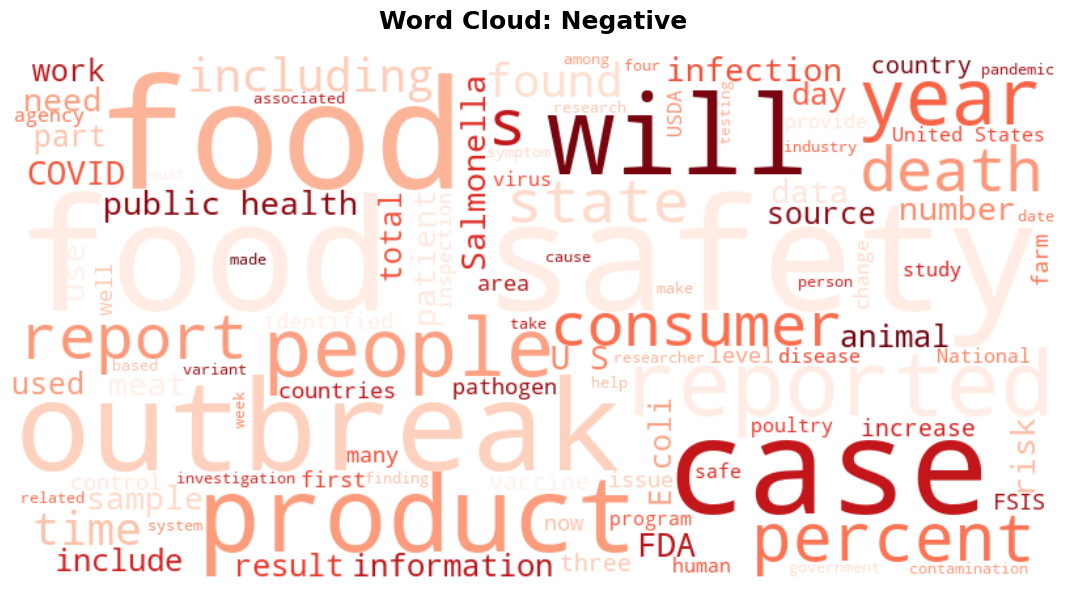

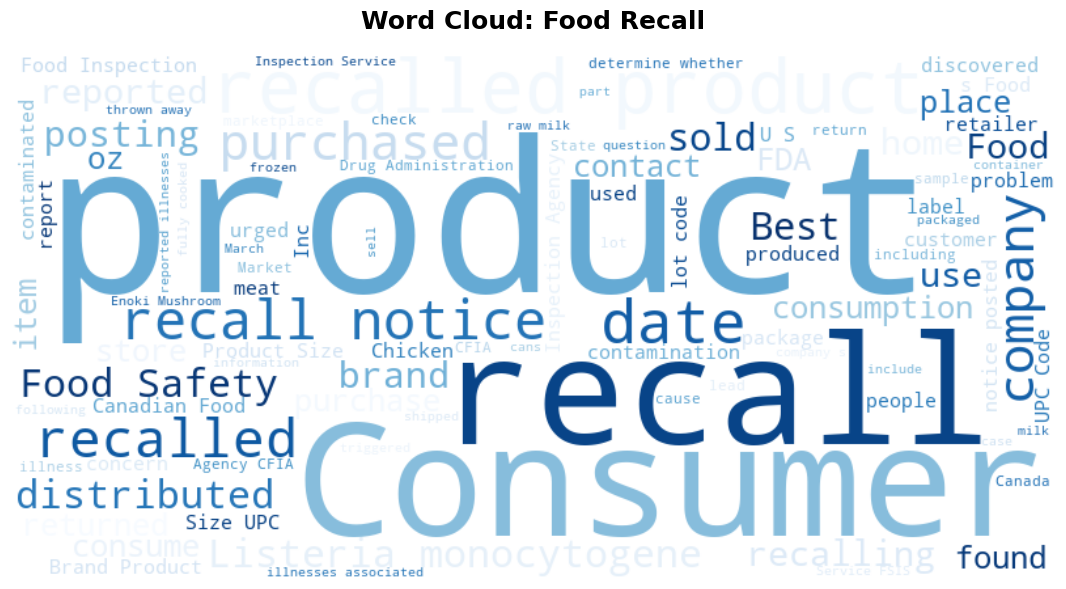

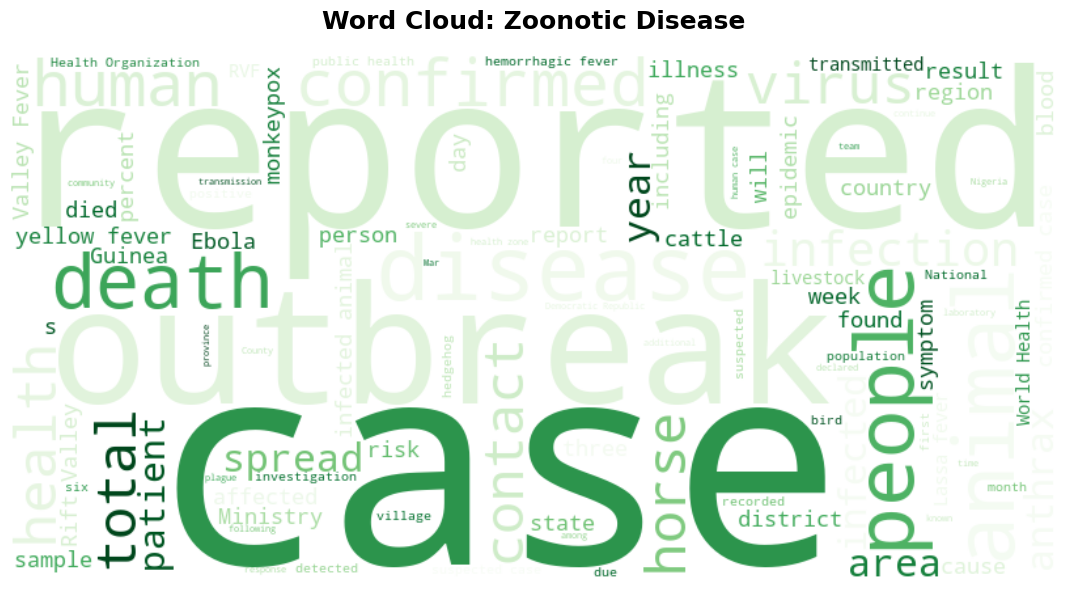

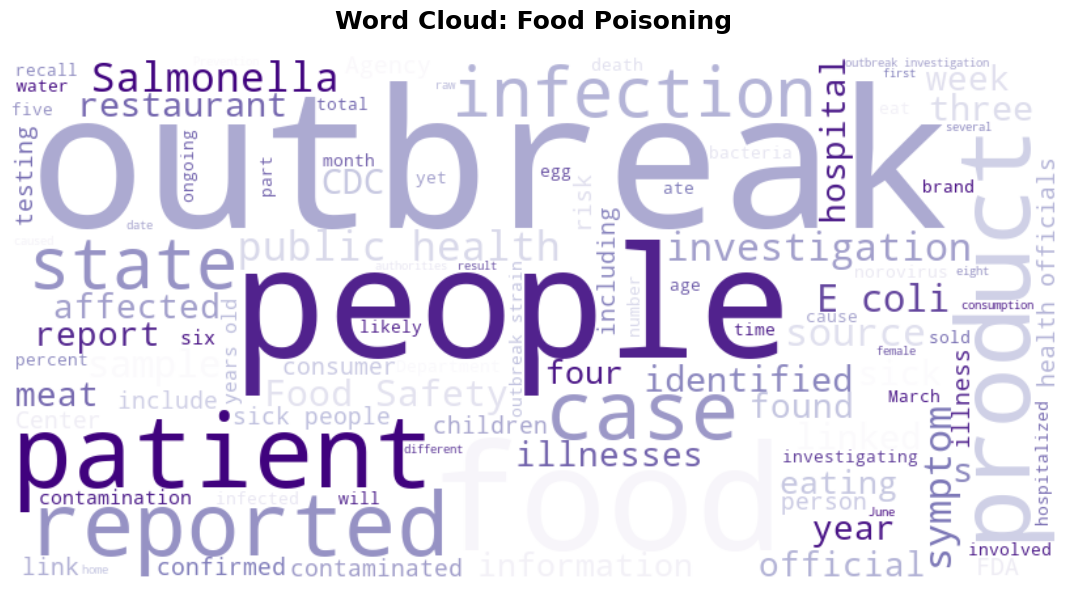

In [19]:
# Word clouds by class
def generate_wordcloud(texts, title, color):
    """Generate word cloud for given texts."""
    text = ' '.join(texts)
    
    stopwords_set = set(STOPWORDS)
    stopwords_set.update(['said', 'says', 'also', 'would', 'could', 'one', 'two', 'may', 'according', 'new'])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords_set,
        colormap=color,
        max_words=100,
        relative_scaling=0.5
    ).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.tight_layout()
    return plt

# Generate word clouds for each class
colormaps = ['Reds', 'Blues', 'Greens', 'Purples']

for idx, label in enumerate(df_single['type'].value_counts().index[:4]):
    texts = df_single[df_single['type'] == label]['text'].tolist()
    plt = generate_wordcloud(texts, f'Word Cloud: {label}', colormaps[idx])
    plt.show()

In [20]:
# TF-IDF top terms by class
def get_tfidf_top_terms(df, label_col='type', text_col='text', top_n=15):
    """Get top TF-IDF terms for each class."""
    results = {}
    
    for label in df[label_col].unique():
        texts = df[df[label_col] == label][text_col].tolist()
        
        vectorizer = TfidfVectorizer(
            max_features=top_n,
            stop_words='english',
            ngram_range=(1, 2)
        )
        
        try:
            X = vectorizer.fit_transform(texts)
            feature_names = vectorizer.get_feature_names_out()
            scores = X.mean(axis=0).A1
            results[label] = pd.DataFrame({
                'term': feature_names,
                'tfidf_score': scores
            }).sort_values('tfidf_score', ascending=False)
        except:
            results[label] = pd.DataFrame(columns=['term', 'tfidf_score'])
    
    return results

tfidf_results = get_tfidf_top_terms(df_single[~df_single['is_multilabel']])

console.print("\n[bold cyan]📊 Top TF-IDF Terms by Class:[/bold cyan]\n")
for label, df_tfidf in list(tfidf_results.items())[:4]:
    console.print(f"\n[yellow]{label}:[/yellow]")
    console.print(df_tfidf.head(10).to_string(index=False))

📊 Top TF-IDF Terms by Class:

Negative:

term  tfidf_score
       food     0.297033
      cases     0.203585
     health     0.164602
   outbreak     0.153041
       said     0.138839
     safety     0.132503
   reported     0.124109
     people     0.121650
food safety     0.113715
   products     0.108745

Zoonotic Disease:

term  tfidf_score
    cases     0.272547
   health     0.195979
    fever     0.192104
  disease     0.183832
 reported     0.174004
 outbreak     0.158975
confirmed     0.155261
    virus     0.146049
     case     0.132151
   people     0.119491

Food Poisoning:

term  tfidf_score
  outbreak     0.283477
    people     0.267157
      food     0.256671
    health     0.189862
salmonella     0.181606
  reported     0.172277
     cases     0.155825
  patients     0.154701
      sick     0.141294
 according     0.133083

Food Recall:

term  tfidf_score
  products     0.321896
   product     0.258985
    recall     0.254772
  recalled     0.221307
 consumers     0.185334
      food     0.183066
      2021     0.152124
     brand     0.132193
    notice     0.122601
inspection     0.115299

In [21]:
# Readability analysis
readability_stats = df_train[['flesch_reading_ease', 'flesch_kincaid_grade']].describe()

console.print("\n[bold cyan]📖 Readability Statistics (Sample of 500):[/bold cyan]\n")
console.print(readability_stats)
console.print("\n[dim]Flesch Reading Ease: 90-100 = Very Easy, 0-30 = Very Difficult[/dim]")
console.print("[dim]Flesch-Kincaid Grade: US grade level required to understand text[/dim]")

📖 Readability Statistics (Sample of 500):

flesch_reading_ease  flesch_kincaid_grade
count           500.000000            500.000000
mean             43.487031             12.255899
std              10.624135              2.388605
min             -15.994375              4.964163
25%              36.305835             10.734077
50%              43.655436             12.189415
75%              50.141157             13.646050
max              82.626425             37.351875

Flesch Reading Ease: 90-100 = Very Easy, 0-30 = Very Difficult

Flesch-Kincaid Grade: US grade level required to understand text

<a id='5-temporal'></a>
## 5. 📅 Temporal Analysis

In [22]:
# Parse dates
def parse_date(date_str):
    """Parse date string to datetime."""
    if date_str is None or pd.isna(date_str):
        return pd.NaT
    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

df_all['parsed_date'] = df_all['date'].apply(parse_date)
df_all['year'] = df_all['parsed_date'].dt.year
df_all['month'] = df_all['parsed_date'].dt.month
df_all['year_month'] = df_all['parsed_date'].dt.to_period('M')

# Remove NaT
df_temporal = df_all[df_all['parsed_date'].notna()].copy()

console.print(f"\n[green]✅ Parsed {len(df_temporal)} / {len(df_all)} dates successfully[/green]")
console.print(f"[yellow]({len(df_all) - len(df_temporal)} samples without dates will be excluded from temporal analysis)[/yellow]")

✅ Parsed 1684 / 2269 dates successfully

(585 samples without dates will be excluded from temporal analysis)

In [23]:
# Articles over time
articles_over_time = df_temporal.groupby('year').size().reset_index(name='count')

fig = px.line(
    articles_over_time,
    x='year',
    y='count',
    title='Number of Articles by Year',
    markers=True,
    color_discrete_sequence=[COLORS[0]]
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Articles',
    height=400,
    title_font_size=20
)

fig.show()

In [24]:
# Class distribution over time (single-label only)
df_temporal_single = df_temporal[~df_temporal['is_multilabel']].copy()

# Get top 4 classes
top_classes = df_temporal_single['type'].value_counts().index[:4]
df_temporal_top = df_temporal_single[df_temporal_single['type'].isin(top_classes)]

# Group by year and class
temporal_class = df_temporal_top.groupby(['year', 'type']).size().reset_index(name='count')

fig = px.area(
    temporal_class,
    x='year',
    y='count',
    color='type',
    title='Class Distribution Over Time (Stacked Area)',
    color_discrete_sequence=COLORS
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Articles',
    height=500,
    title_font_size=20
)

fig.show()

<a id='6-entities'></a>
## 6. 🏷️ Entity Analysis

In [25]:
# Extract entities from dataset
def extract_all_entities(data_list):
    """Extract all entities from the dataset."""
    all_entities = defaultdict(list)
    
    for item in tqdm(data_list, desc="Extracting entities"):
        for sentence_data in item.get('entities', []):
            entities = sentence_data.get('Entities', {})
            for entity_type, entity_list in entities.items():
                for entity_info in entity_list:
                    entity_text = entity_info[0] if isinstance(entity_info, list) else entity_info
                    all_entities[entity_type].append({
                        'text': entity_text,
                        'article_id': item['id'],
                        'article_type': item['type']
                    })
    
    return all_entities

train_entities = extract_all_entities(train_data)
test_entities = extract_all_entities(test_data)

console.print("[green]✅ Entities extracted![/green]")
console.print(f"\nEntity types found: {list(train_entities.keys())}")

Extracting entities:   0%|          | 0/2011 [00:00<?, ?it/s]

Extracting entities:   0%|          | 0/258 [00:00<?, ?it/s]

✅ Entities extracted!

Entity types found: ['DATE', 'ORG', 'CAUSATIVE_AGENT', 'LOCATION', 'LOC', 'ANIMAL_PLANT', 'FOOD', 
'UNCERTAINTY_KEYWORDS', 'FOODBORNE_DISEASE', 'PATHOGEN', 'SYMPTOMS', 'ZOONOTIC_DISEASE']

In [26]:
# Entity type distribution
entity_type_counts = {k: len(v) for k, v in train_entities.items()}
df_entity_types = pd.DataFrame(list(entity_type_counts.items()), columns=['Entity Type', 'Count'])
df_entity_types = df_entity_types.sort_values('Count', ascending=False)

fig = px.bar(
    df_entity_types,
    x='Entity Type',
    y='Count',
    title='Entity Type Distribution (Training Set)',
    color='Count',
    color_continuous_scale='Viridis',
    text='Count'
)

fig.update_traces(textposition='outside')
fig.update_layout(height=500, showlegend=False, title_font_size=20)
fig.show()

In [27]:
# Top entities by type
console.print("\n[bold cyan]🏷️ Top Entities by Type:[/bold cyan]\n")

for entity_type in ['ORG', 'GPE', 'PERSON', 'PRODUCT', 'DATE'][:5]:
    if entity_type in train_entities:
        entity_texts = [e['text'].lower() for e in train_entities[entity_type]]
        entity_counts = Counter(entity_texts).most_common(10)
        
        console.print(f"\n[yellow]{entity_type}:[/yellow]")
        for entity, count in entity_counts:
            console.print(f"  {entity}: {count}")

🏷️ Top Entities by Type:

ORG:

fda: 1888

salmonella: 967

listeria: 794

usda: 757

fsis: 740

who: 614

cdc: 519

eu: 388

campylobacter: 383

food and drug administration: 295

DATE:

may: 1629

june: 203

dec: 185

march: 181

mar 2021: 177

jan: 174

oct: 173

july: 167

january: 163

april: 157

In [28]:
# Food safety specific entities (pathogens, contaminants)
# Define keywords
pathogens = [
    'salmonella', 'listeria', 'e. coli', 'e.coli', 'escherichia coli',
    'campylobacter', 'norovirus', 'hepatitis', 'shigella',
    'staphylococcus', 'clostridium', 'botulism'
]

contaminants = [
    'metal', 'plastic', 'glass', 'foreign', 'allergen',
    'pesticide', 'chemical', 'antibiotic'
]

# Search in text
def count_keyword_mentions(df, keywords):
    """Count mentions of keywords in text."""
    counts = {}
    for keyword in keywords:
        pattern = f'\\b{keyword}\\b'
        counts[keyword] = df['text'].str.lower().str.count(pattern).sum()
    return counts

pathogen_counts = count_keyword_mentions(df_train, pathogens)
contaminant_counts = count_keyword_mentions(df_train, contaminants)

# Visualize pathogens
df_pathogens = pd.DataFrame(list(pathogen_counts.items()), columns=['Pathogen', 'Mentions'])
df_pathogens = df_pathogens[df_pathogens['Mentions'] > 0].sort_values('Mentions', ascending=False)

fig = px.bar(
    df_pathogens.head(10),
    x='Mentions',
    y='Pathogen',
    orientation='h',
    title='Top 10 Pathogen Mentions in Training Data',
    color='Mentions',
    color_continuous_scale='Reds',
    text='Mentions'
)

fig.update_traces(textposition='outside')
fig.update_layout(height=500, showlegend=False, title_font_size=20)
fig.show()

<a id='7-multilabel'></a>
## 7. 🔀 Multi-Label Investigation

In [29]:
# Multi-label combinations
multilabel_samples = df_train[df_train['is_multilabel']]
multilabel_counts = multilabel_samples['type'].value_counts()

console.print("\n[bold cyan]🔀 Multi-Label Combinations:[/bold cyan]\n")
console.print(multilabel_counts)

# Visualize
fig = px.bar(
    x=multilabel_counts.values,
    y=multilabel_counts.index,
    orientation='h',
    title=f'Multi-Label Combinations ({len(multilabel_samples)} total samples)',
    labels={'x': 'Count', 'y': 'Label Combination'},
    color=multilabel_counts.values,
    color_continuous_scale='Blues',
    text=multilabel_counts.values
)

fig.update_traces(textposition='outside')
fig.update_layout(height=400, showlegend=False, title_font_size=20)
fig.show()

🔀 Multi-Label Combinations:

type
Food Poisoning; Food Recall         80
Zoonotic Disease; Food Poisoning    13
Food Poisoning; Zoonotic Disease     3
Name: count, dtype: int64

In [30]:
# Label co-occurrence matrix
from sklearn.preprocessing import MultiLabelBinarizer

# Split multi-labels
all_labels_split = df_train['type'].str.split('; ').tolist()

# Binarize
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(all_labels_split)

# Co-occurrence matrix
cooccurrence = np.dot(label_matrix.T, label_matrix)
df_cooccurrence = pd.DataFrame(cooccurrence, index=mlb.classes_, columns=mlb.classes_)

# Heatmap
fig = px.imshow(
    df_cooccurrence,
    title='Label Co-occurrence Matrix',
    color_continuous_scale='YlOrRd',
    aspect='auto',
    text_auto=True
)

fig.update_layout(height=600, title_font_size=20)
fig.show()

console.print("\n[dim]Diagonal = number of samples with that label[/dim]")
console.print("[dim]Off-diagonal = number of samples with both labels[/dim]")

Diagonal = number of samples with that label

Off-diagonal = number of samples with both labels

In [31]:
# Sankey diagram for multi-label flow
# Extract label pairs
label_pairs = []
for labels in multilabel_samples['type']:
    if '; ' in labels:
        parts = labels.split('; ')
        for i in range(len(parts) - 1):
            label_pairs.append((parts[i], parts[i+1]))

# Count pairs
pair_counts = Counter(label_pairs)

# Prepare for Sankey
all_labels_unique = list(set([l for pair in label_pairs for l in pair]))
label_to_idx = {label: idx for idx, label in enumerate(all_labels_unique)}

sources = [label_to_idx[pair[0]] for pair in pair_counts.keys()]
targets = [label_to_idx[pair[1]] for pair in pair_counts.keys()]
values = list(pair_counts.values())

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=all_labels_unique,
        color=COLORS[:len(all_labels_unique)]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title_text='Multi-Label Combinations (Sankey Diagram)',
    height=500,
    title_font_size=20
)

fig.show()

In [32]:
# Primary label extraction strategy
def extract_primary_label(label_str):
    """Extract primary label based on priority."""
    priority = [
        'Food Poisoning',
        'Zoonotic Disease',
        'Food Recall',
        'Negative'
    ]
    
    if '; ' not in label_str:
        return label_str
    
    labels = label_str.split('; ')
    
    # Return highest priority
    for priority_label in priority:
        if priority_label in labels:
            return priority_label
    
    return labels[0]  # fallback

# Apply extraction
df_train['primary_label'] = df_train['type'].apply(extract_primary_label)
df_test['primary_label'] = df_test['type'].apply(extract_primary_label)

# Compare before/after
console.print("\n[bold cyan]📊 Label Distribution After Primary Extraction:[/bold cyan]\n")

comparison = pd.DataFrame({
    'Original': df_train['type'].value_counts().head(4),
    'Primary Only': df_train['primary_label'].value_counts()
})

console.print(comparison)

# Visualize change
fig = go.Figure()

original_counts = df_train[~df_train['is_multilabel']]['type'].value_counts()
primary_counts = df_train['primary_label'].value_counts()

labels = list(primary_counts.index)

fig.add_trace(go.Bar(
    name='Original (Single-Label)',
    x=labels,
    y=[original_counts.get(l, 0) for l in labels],
    marker_color=COLORS[0]
))

fig.add_trace(go.Bar(
    name='After Primary Extraction',
    x=labels,
    y=[primary_counts.get(l, 0) for l in labels],
    marker_color=COLORS[1]
))

fig.update_layout(
    title='Class Distribution: Before vs After Primary Label Extraction',
    xaxis_title='Class',
    yaxis_title='Count',
    barmode='group',
    height=500,
    title_font_size=20
)

fig.show()

📊 Label Distribution After Primary Extraction:

Original  Primary Only
Food Poisoning         129           225
Food Recall            195           195
Negative              1419          1419
Zoonotic Disease       172           172

<a id='8-findings'></a>
## 8. 🎯 Key Findings & Recommendations

### 📊 Summary of Findings

#### 1. **Severe Class Imbalance** ⚠️
- **Negative class dominates**: 70.6% of training data
- **Food Poisoning is most underrepresented**: Only 6.4% (129 samples)
- **Imbalance ratio**: ~11:1 (Negative vs Food Poisoning)
- **Impact**: Models will be heavily biased toward Negative class without intervention

#### 2. **Long Document Challenge** 📏
- **Mean text length**: 3,017 characters (~750 tokens)
- **50%+ articles exceed BERT limit** (512 tokens)
- **Maximum length**: 28,749 characters (~7,187 tokens)
- **Solution needed**: Sentence ranking or hierarchical processing

#### 3. **Multi-Label Complexity** 🔀
- **96 samples (4.8%)** have multiple labels
- **Most common**: Food Poisoning; Food Recall (80 samples)
- **Recommendation**: Extract primary label (implemented above)
- **Result**: Clean 4-class single-label classification

#### 4. **Entity Richness** 🏷️
- Dataset contains **sentence-level entity annotations**
- **Key entities**: Organizations, pathogens, locations, products
- **Opportunity**: Use entities for feature engineering or attention mechanisms

#### 5. **Text Characteristics** 📝
- **Readability**: Professional news writing (Flesch-Kincaid grade ~11-13)
- **Vocabulary**: Domain-specific terms (Salmonella, Listeria, FDA, recall)
- **Structure**: Inverted pyramid (key info at beginning)

---

### 🎯 Recommendations

#### Data Preprocessing
1. ✅ **Use primary label extraction** (already implemented)
2. ✅ **Apply sentence ranking** (TF-IDF top 50%) for long documents
3. ✅ **Stratified sampling** to maintain class distribution in splits
4. ✅ **Remove duplicates** and near-duplicates

#### Handling Class Imbalance
1. **Focal Loss** instead of cross-entropy (γ=2.0)
2. **Data Augmentation**:
   - LLM synthetic generation (200 samples per minority class)
   - Back-translation (3 languages)
   - Entity-aware augmentation
3. **SMOTE** for baseline models
4. **Stratified K-fold CV** for evaluation

#### Model Selection
1. **Baseline**: TF-IDF + Logistic Regression (class-weighted)
2. **Few-shot**: SetFit with 16 examples per class
3. **Encoder**: DeBERTa-v3-base + sentence ranking
4. **Decoder**: Qwen2.5-3B-Instruct + Unsloth QLoRA
5. **Ensemble**: Soft voting (DeBERTa 0.4 + Qwen 0.4 + SetFit 0.2)

#### Evaluation Strategy
1. **Primary metric**: Macro F1 (equal weight to all classes)
2. **Secondary**: Per-class F1, especially Food Poisoning
3. **Cross-validation**: 5-fold stratified
4. **Hold-out test**: 258 samples (DO NOT TOUCH until final eval)

---

### 🚀 Next Steps

1. ✅ **Completed**: EDA and data understanding
2. 📝 **Next**: Build modular preprocessing pipeline
3. 🎯 **Then**: Implement baseline models
4. 🤖 **Finally**: Train advanced models (DeBERTa, Qwen)

---

### 📈 Expected Performance

| Model | Macro F1 | Food Poisoning F1 | Training Time |
|-------|----------|-------------------|---------------|
| TF-IDF + LR | 68-72% | 55-60% | 2 min |
| SetFit | 80-83% | 68-72% | 5 min |
| DeBERTa | 82-85% | 72-76% | 3 hrs |
| Qwen LoRA | 87-90% | 78-82% | 4 hrs |
| **Ensemble** | **89-92%** | **81-85%** | - |

---

**End of EDA Report** 🎉

In [ ]:
# Save processed data for next steps
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Save with primary labels
df_train[['id', 'title', 'text', 'type', 'primary_label', 'date', 'url']].to_csv(
    output_dir / 'train_processed.csv', index=False
)

df_test[['id', 'title', 'text', 'type', 'primary_label', 'date', 'url']].to_csv(
    output_dir / 'test_processed.csv', index=False
)

console.print("\n[green]✅ Processed data saved to data/processed/[/green]")
console.print("[green]✅ EDA complete! Ready for modeling.[/green]")

✅ Processed data saved to data/processed/

✅ EDA complete! Ready for modeling.